In [71]:
import pandas as pd
import numpy as np
from ipywidgets import interact
import matplotlib.pyplot as plt

In [72]:
def simplify_column_names( df: pd.DataFrame, col_names: list, prefixes: list) -> pd.DataFrame:
    '''
    For a given dataframe, renames lists of column names with a shared prefix and applies a sequential counter after each prefix.

    Example: In dataframe df, columns groups [['hello', 'world'], ['foo','bar']], prefixes ['a','b'] would yield new column names
    a_1, a_2, b_1, b_2
    '''
    for c, p in zip(col_names, prefixes):
        rename_map = { i : f"{p}_{str(c.index(i) + 1)}" for i in c}
        df.rename(rename_map, axis=1, inplace=True )
    
    return df

In [73]:
def strip_chars(string : str):
    '''
    Strips all non-numeric characters and returns the rest as a single int
    '''
    string = string.replace('%','')
    if string == 'NA':
        return 'NA'
    res = ''.join([i for i in string.split() if i.isdigit()])
    if res:
        return int(''.join([i for i in string.split() if i.isdigit()]))
    else:
        return 0

In [74]:
def convert_to_percentage_with_negatives(string : str):
    '''
    Strips all non-numeric characters and returns the rest as a single int
    '''
    if string == 'NA':
        return 'NA'
    string = string.replace('%','')
    modifier = -1 if 'less' in string else 1
    res = ''.join([i for i in string.split() if i.isdigit()])
    if res:
        return int(''.join([i for i in string.split() if i.isdigit()])) * modifier
    else:
        return 0

In [75]:
strong_disagree_strong_agree_map = {
    'Strongly disagree' : -2,
    'Somewhat disagree' : -1,
    'Neither agree nor disagree' : 0,
    'Somewhat agree' : 1,
    'Strongly agree' : 2,
    'NA' : 'NA'
}


def encode_ordinal(string : str, ordinal_map = strong_disagree_strong_agree_map) -> int:
    '''
    Converts common ordinal responses to representations based on given map

    string : str
        string to be evaluated and converted to a different representation based on the map
    ordinal_map : dict
        a dict with strings as keys, representations as values. Key evaluation is case-sensitive
    '''
    # print(f"Evaluating: |{string}|")
    if ordinal_map.get(string) or ordinal_map.get(string) == 0:
        return ordinal_map[string]
    else:
        print('Unknown response found')
        return 'Unknown'


In [76]:
pd.set_option('display.max_colwidth', None)

In [77]:
data_dir = '../data/'

In [78]:
raw_data = pd.read_csv(data_dir + '2021_rws.csv', encoding='cp1252')

In [79]:
raw_data.shape

(1512, 109)

Drop columns we know we will not be examining

- Columns pertaining to collaborating remotely with onsite employees (column indices 65-92)

In [80]:
remote_onsite_cols = raw_data.columns[65:93]

In [81]:
df = raw_data.drop( columns= remote_onsite_cols)

In [82]:
df.shape

(1512, 81)

Trim leading/trailing whitespace in columns

In [83]:
column_name_trimmed = { k : k.strip() for k in df.columns}
df.rename(column_name_trimmed, axis=1, inplace=True)

In [84]:
cols = list(df.columns)

Renaming columns from original survey questions to more workable column names

In [85]:
# Columns indices from column mapping file
# Values maintained as lists to support simplify_column_names function
column_map = {
    'demographics' : cols[1:4] + cols[7:9],
    'company' : cols[4:7],
    'remote_work_time' : cols[9:14],
    'remote_policy' : cols[14:15] + cols[18:25],
    'split_work_day' : cols[15:18],
    'remote_culture' : cols[25:37],
    'use_of_time_onsite' : cols[37:42],
    'use_of_time_remote' : cols[42:47],
    'compensation_hypothetical' : cols[47:49],
    'barriers' : cols[49:65],
    'remote_personal_behavior' : cols[65:68],
    'remote_management' : cols[68:79] + cols[80:81],
    'productivity' : cols[79:80]
    
}

In [86]:
df = simplify_column_names( df, column_map.values() , column_map.keys() )

In [87]:
df.rename( {'Response ID' : 'id'}, axis=1, inplace=True)

In [88]:
df['id'].unique()

array([   1,    2,    3, ..., 1510, 1511, 1512], dtype=int64)

In [89]:
@interact

def df_answer_explorer(column = df.columns):
    '''
    Allows quick views of all unique answers for a given response question
    
    '''
    if column != 'id': 
        # answers = list(df[column].unique())
        column_name_parts = column.rsplit('_' ,1 )
        response_question = column_map[column_name_parts[0]][int(column_name_parts[1]) - 1]
        vk_column_counts = { df[df[column] == i].shape[0] : i for i in df[column].unique() }
        sorted_kv_column_counts = { vk_column_counts[i] : i for i in sorted(vk_column_counts, reverse=True)}
        
        print("Survey question:")
        print(response_question)
        print("")
        print(f"Number of null responses: {df[column].isnull().sum()}")
        print("")
        result_df = pd.DataFrame(sorted_kv_column_counts.values(), index=sorted_kv_column_counts.keys())
        result_df.rename({0 : 'Count'}, axis=1, inplace=True)
        return result_df
    else:
        print(f"'id' is a numerical range from 1 to {df.shape[0]}")

interactive(children=(Dropdown(description='column', options=('id', 'demographics_1', 'demographics_2', 'demog…

## Reforming survey responses to numeric values where possible

This will allow us to more easily access statistical measures and implement some machine learning analysis. The information encoded in the responses will remain the same, just represented differently.

Features (survey questions) addressed are those such as:
- Those allowing the responder to select a percentage (the original responses contain flavor text that can be eliminated)
- Those on a "Agree" scale that can be replaced with ordinal representations
- Yes/No that can be binarized

In [90]:
# Start by making a copy to manipulate, so we can compare original values to new ones
tidy_df = df.copy()

### Binarize responses across all columns where possible
'Yes' = 1; 'No' = 0

In [91]:
for col in tidy_df.columns:
    if tidy_df[col].dtype == 'O':
        responses = tidy_df[col].str.lower().unique()
        if len(responses) == 2 and 'yes' in responses and 'no' in responses:
            tidy_df[col] = tidy_df[col].str.lower()
            tidy_df[col] = np.where(tidy_df[col] == 'yes', 1, 0)

### Recreate "year born" as "age" based on year this survey took place (2021)

In [92]:
tidy_df['demographics_1'] = 2021 - df['demographics_1']

### Recreate "Metro or Regional" as "Metro" and make binary

In [93]:
tidy_df['demographics_5'] = np.where(tidy_df['demographics_5'] == 'Metro', 1, 0)

### "Remote work time" percentage questions as numeric

**Note**: In these questions, "Less than 10%"" is distinct from "10%" and "Rarely or never", but still represents that the responder went onsite at least for a few hours in the week. The result of the function would combine it with those distinctly answering "10%", so I have deliberately created a new distinct value splitting the difference - 5%

In [94]:
for i in range(1,6):
    tidy_df[f"remote_work_time_{i}"] = np.where(tidy_df[f"remote_work_time_{i}"] == 'Less than 10% of my time', '5', tidy_df[f"remote_work_time_{i}"])
    tidy_df[f"remote_work_time_{i}"] = tidy_df[f"remote_work_time_{i}"].apply(strip_chars)

### Remote policy

In [95]:
tidy_df[f"remote_policy_3"].dtype

dtype('O')

In [96]:
tidy_df[f"remote_policy_3"].isnull().sum()

750

In [97]:
tidy_df[f"remote_policy_3"] = tidy_df[f"remote_policy_3"].fillna('NA')
tidy_df[f"remote_policy_3"] = np.where(tidy_df[f"remote_policy_3"] == 'Less than 10% of my time', '5', tidy_df[f"remote_policy_3"])
tidy_df[f"remote_policy_3"] = tidy_df[f"remote_policy_3"].apply(strip_chars)

In [98]:
strong_disagree_strong_agree_map.get('Neither agree nor disagree')


0

In [99]:
for i in range(4,8):
    tidy_df[f'remote_policy_{i}'] = tidy_df[f'remote_policy_{i}'].apply(encode_ordinal)

In [100]:
strong_neg_strong_pos_map = {
    'Strongly Negative' : -2,
    'Somewhat Negative' : -1,
    'Neither positive nor negative' : 0,
    'Somewhat Positive' : 1,
    'Strongly Positive' : 2   
}

tidy_df['remote_policy_8'] = tidy_df['remote_policy_8'].apply(lambda s: encode_ordinal(string = s, ordinal_map= strong_neg_strong_pos_map))

### Split work day

In [101]:
for i in range(2,4):
    tidy_df[f"split_work_day_{i}"] = tidy_df[f"split_work_day_{i}"].fillna('NA')
    tidy_df[f"split_work_day_{i}"] = np.where(tidy_df[f"split_work_day_{i}"] == 'Less than 10% of my time', '5', tidy_df[f"split_work_day_{i}"])
    tidy_df[f"split_work_day_{i}"] = tidy_df[f"split_work_day_{i}"].apply(strip_chars)

### Remote Culture

In [102]:
for i in range(1,8):
    tidy_df[f'remote_culture_{i}'] = tidy_df[f'remote_culture_{i}'].apply(encode_ordinal)

In [103]:
tidy_df['remote_culture_8'] = tidy_df['remote_culture_8'].apply(lambda s: encode_ordinal(string = s, ordinal_map= strong_neg_strong_pos_map))

In [104]:
very_unlikely_very_likely_map = {
    'Very unlikely' : -2,
    'Somewhat unlikely' : -1,
    'Neither unlikely or likely' : 0,
    'Somewhat likely' : 1,
    'Very likely' : 2   
}

for i in range(10,13):
    tidy_df[f'remote_culture_{i}'] = tidy_df[f'remote_culture_{i}'].apply(lambda s : encode_ordinal(string = s, ordinal_map= very_unlikely_very_likely_map))

### Use of time - Onsite

Address some questionable nulls by filling with median or mean depending on skewness

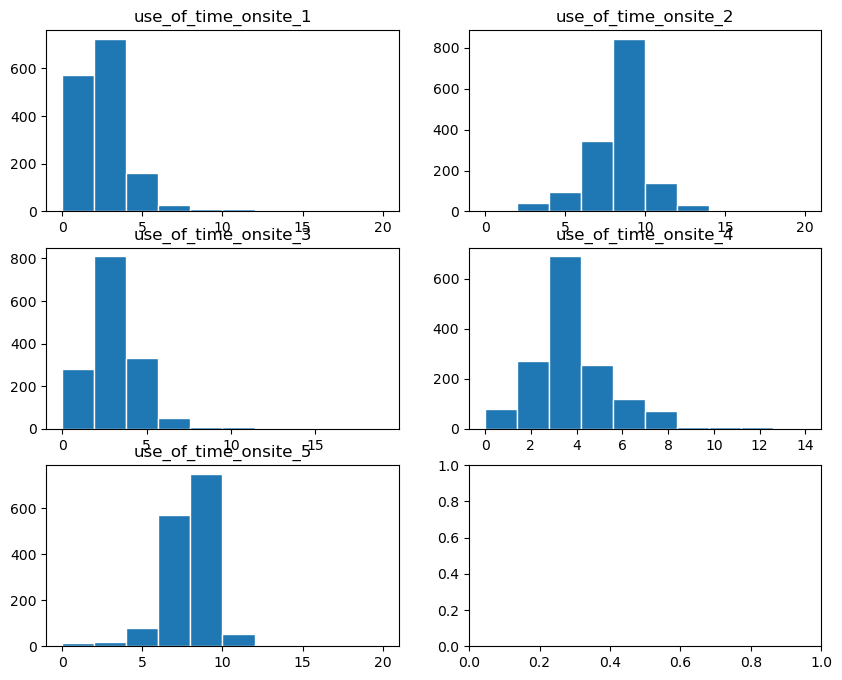

In [105]:
fig, axs = plt.subplots(3 , 2, figsize=(10,8))

i = 1
for y in range(3):
    for x in range(2):
        if i < 6:
            axs[y,x].hist(tidy_df[f"use_of_time_onsite_{i}"], edgecolor='white');
            axs[y,x].set_title(f"use_of_time_onsite_{i}")
            i+=1

In [106]:
tidy_df['use_of_time_onsite_1'] = tidy_df['use_of_time_onsite_1'].fillna(np.median(tidy_df[~tidy_df['use_of_time_onsite_1'].isnull()]['use_of_time_onsite_1']))

tidy_df['use_of_time_onsite_2'] = tidy_df['use_of_time_onsite_2'].fillna(round(tidy_df['use_of_time_onsite_2'].mean(), 1))

tidy_df['use_of_time_onsite_3'] = tidy_df['use_of_time_onsite_3'].fillna(np.median(tidy_df[~tidy_df['use_of_time_onsite_3'].isnull()]['use_of_time_onsite_3']))

tidy_df['use_of_time_onsite_4'] = tidy_df['use_of_time_onsite_4'].fillna(round(tidy_df['use_of_time_onsite_4'].mean(), 1))

tidy_df['use_of_time_onsite_5'] = tidy_df['use_of_time_onsite_5'].fillna(round(tidy_df['use_of_time_onsite_5'].mean(), 1))

### Use of time - Remote

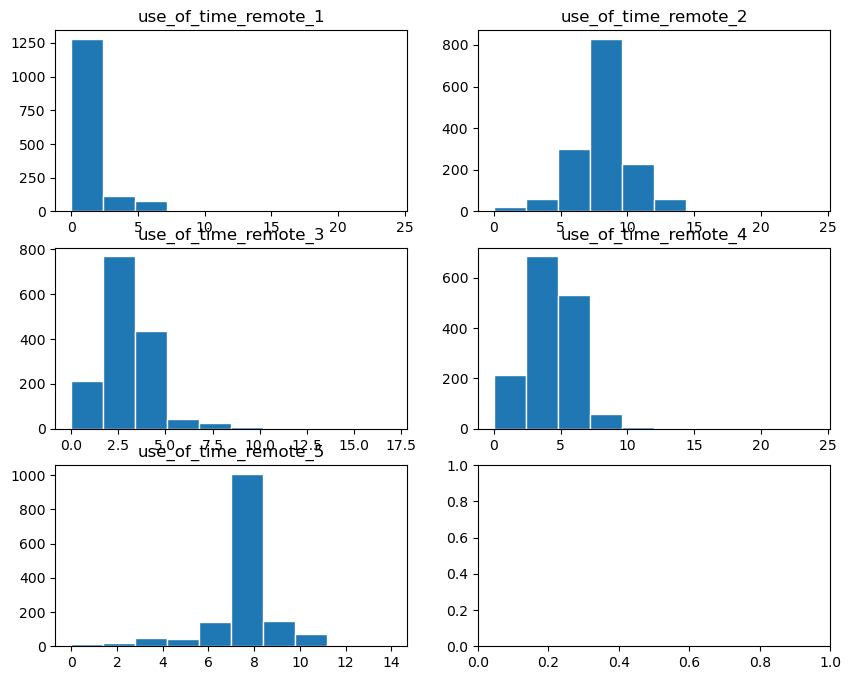

In [107]:
fig, axs = plt.subplots(3 , 2, figsize=(10,8))

i = 1
for y in range(3):
    for x in range(2):
        if i < 6:
            axs[y,x].hist(tidy_df[f"use_of_time_remote_{i}"], edgecolor='white');
            axs[y,x].set_title(f"use_of_time_remote_{i}")
            i+=1

In [108]:
tidy_df['use_of_time_remote_1'] = tidy_df['use_of_time_remote_1'].fillna(np.median(tidy_df[~tidy_df['use_of_time_remote_1'].isnull()]['use_of_time_remote_1']))

tidy_df['use_of_time_remote_2'] = tidy_df['use_of_time_remote_2'].fillna(round(tidy_df['use_of_time_remote_2'].mean(), 1))

tidy_df['use_of_time_remote_3'] = tidy_df['use_of_time_remote_3'].fillna(np.median(tidy_df[~tidy_df['use_of_time_remote_3'].isnull()]['use_of_time_remote_3']))

tidy_df['use_of_time_remote_4'] = tidy_df['use_of_time_remote_4'].fillna(round(tidy_df['use_of_time_remote_4'].mean(), 1))

tidy_df['use_of_time_remote_5'] = tidy_df['use_of_time_remote_5'].fillna(round(tidy_df['use_of_time_remote_5'].mean(), 1))

### Compensation Hypothetical

<Axes: >

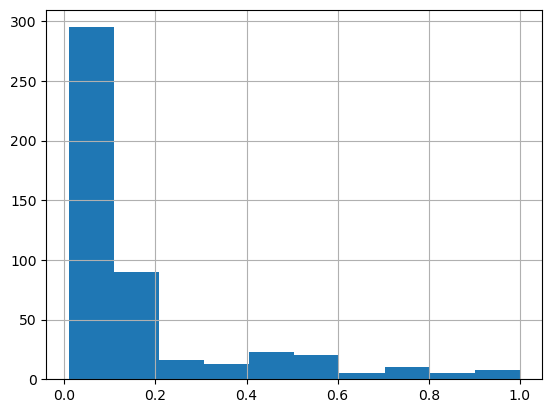

In [109]:
tidy_df['compensation_hypothetical_2'].hist()

In [110]:
tidy_df['compensation_hypothetical_2'] = tidy_df['compensation_hypothetical_2'].fillna('NA')

### Remote Barriers

In these questions, ordinal data is a bit of a challenge because of two similar neutral answers "Stayed about the same" and "Not a barrier for me".

In the context of the questions being related to the change in remote working conditions, these could be interpreted as being alike since they suggest no noticeable change to the responders current working environment. For this reason, I have combined them to maintain an ordinal data response.

In [111]:
barriers_map = {
    'Significantly worsened' : -2,
    'Somewhat worsened' : -1,
    'Not a barrier for me' : 0,
    'Stayed about the same' : 0,
    'Somewhat improved' : 1,
    'Significantly improved' : 2
}

for i in range(1,17):
    tidy_df[f'barriers_{i}'] = tidy_df[f'barriers_{i}'].apply(lambda s : encode_ordinal(string = s, ordinal_map= barriers_map))

### Remote Personal Behavior

In [112]:
for i in range(1,4):
    tidy_df[f'remote_personal_behavior_{i}'] = tidy_df[f'remote_personal_behavior_{i}'].apply(lambda s : encode_ordinal(string = s, ordinal_map= strong_disagree_strong_agree_map))

### Remote Management

In [113]:
tidy_df['remote_management_2'] = tidy_df['remote_management_2'].fillna('NA') 

In [114]:
tidy_df['remote_management_3'].isnull().sum()

917

In [115]:
for i in range(3,12):
    tidy_df[f"remote_management_{i}"] = tidy_df[f"remote_management_{i}"].fillna('NA') 
    tidy_df[f"remote_management_{i}"] = tidy_df[f"remote_management_{i}"].apply(encode_ordinal)

In [116]:
tidy_df['remote_management_12'] = tidy_df['remote_management_12'].fillna('NA').apply(convert_to_percentage_with_negatives)

### Productivity

In [117]:
tidy_df['productivity_1'] = tidy_df['productivity_1'].apply(convert_to_percentage_with_negatives)

In [118]:
@interact

def tidy_df_answer_explorer(column = tidy_df.columns):
    '''
    Allows quick views of all unique answers for a given response question
    
    '''
    if column != 'id': 
        # answers = list(df[column].unique())
        column_name_parts = column.rsplit('_' ,1 )
        response_question = column_map[column_name_parts[0]][int(column_name_parts[1]) - 1]
        vk_column_counts = { tidy_df[tidy_df[column] == i].shape[0] : i for i in tidy_df[column].unique() }
        sorted_kv_column_counts = { vk_column_counts[i] : i for i in sorted(vk_column_counts, reverse=True)}
        
        print("Survey question:")
        print(response_question)
        print("")
        print(f"Number of null responses: {tidy_df[column].isnull().sum()}")
        print("")
        result_df = pd.DataFrame(sorted_kv_column_counts.values(), index=sorted_kv_column_counts.keys())
        result_df.rename({0 : 'Count'}, axis=1, inplace=True)
        return result_df
    else:
        print(f"'id' is a numerical range from 1 to {df.shape[0]}")

interactive(children=(Dropdown(description='column', options=('id', 'demographics_1', 'demographics_2', 'demog…

In [119]:
all(tidy_df.isnull().sum() == False)

True

In [120]:
#tidy_df.to_csv('../data/2021_rws_tidy_numeric.csv', index=False)

In [121]:
company_controlled_barriers_v_productivity = tidy_df.iloc[:, [0, 50,51,52,53,54,57,61,79]]

In [122]:
#company_controlled_barriers_v_productivity.to_csv('../data/company_controlled_barriers_v_productivity.csv', index = False)

In [123]:
barrier_cols = [col for col in tidy_df.columns if 'barriers' in col ]

In [124]:
barrier_cols.append('id')
barrier_cols.append('productivity_1')

In [125]:
barriers_df = tidy_df[barrier_cols]

In [126]:
barriers_df.to_csv('../data/all_barriers.csv', index = False)

In [127]:
tidy_df[tidy_df['productivity_1'] == 50]['barriers_2'].value_counts()

barriers_2
 0    151
 1     74
 2     35
-1     14
-2      4
Name: count, dtype: int64

In [128]:
tidy_df[tidy_df['productivity_1'] == 50]['barriers_2'].value_counts() / tidy_df[tidy_df['productivity_1'] == 50]['barriers_2'].count()

barriers_2
 0    0.543165
 1    0.266187
 2    0.125899
-1    0.050360
-2    0.014388
Name: count, dtype: float64